# Collaboration and Competition

---


### 1. Start the Environment

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import time
from agent.agent import MADDPG
import torch

from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


When finished, you can close the environment.

# MADDPG

* for episode = 1 to M do:
    * init random process N for action exploration
    * recieve initial state x
    * for t=1 to max-episode-length do:
        * for each agent i, select action with the current agent policy + noise
        * execute actions and observe reward r and new state
        * store (x, a,r, x') in replay buffer
        * x<-x'
        * for agent i=1 to N do:
            * sample a random minibatch of S samples $(x^j, a^j, r^j, x'^j)$ from $D$
            * run gradient descent on sampled policy gradient and update actor-critic

## hyper-parameters
* learning rate: 0.01
* $\tau = 0.01$ for soft-updates
* $\gamma = 0.95 $
* replay buffer size: $10^6$
* update frequency: 100 samples added to replay buffer
* batch-size: 1024   

In [5]:
agent = MADDPG(state_size, action_size)

agent using cuda:0 device
agent using cuda:0 device


In [7]:
def train(n_episodes=3000):
    scores = []
    scores_deque = deque(maxlen=100)
    scores_avg = []
    max_score = 0
    
    for i_episode in range(1,n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        # get initial state
        states = env_info.vector_observations
        agent.reset()
        
        #loop over episodes
        agent_scores = np.zeros(2)
        start_time = time.time()
        while True:
            # select actions for all agents
            actions = agent.act(states)
                       
            # send action to env
            env_info = env.step(actions)[brain_name]
            
            #observe new state, reward
            next_states = env_info.vector_observations
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                       # see if episode finished
            agent.step(states, actions, rewards, next_states, dones)
            
            #update state
            states = next_states
            
            #add agent scores individually
            agent_scores += np.array(rewards)
            
            if any(dones):
                break
        #get max score
        score = agent_scores.max()
        scores.append(score)
        scores_deque.append(score)        
        scores_avg.append(np.mean(scores_deque))
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f} \tTime: {:.2f}'.format(i_episode, 
                                                                                         np.mean(scores_deque), 
                                                                                         np.mean(scores), 
                                                                                         time.time()-start_time), end="")
        if np.mean(scores_deque)>max_score:
            max_score = np.mean(scores_deque)
#             for i, a in enumerate(agent.ddpg_agents):
#                 try:
# #                     torch.save(a.actor_local.state_dict(), 'checkpoint_actor_{}.pth'.format(i))
# #                     torch.save(a.critic_local.state_dict(), 'checkpoint_critic_{}.pth'.format(i))
#                 except:
#                     print("error saving model")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f} \tMax score: {:.2f} \tEpsilon: {:.2f} \tTime: {:.2f}/per episode'.format(i_episode, 
                                                                                                                                np.mean(scores_deque),
                                                                                                                                np.max(scores_deque),
                                                                                                                                agent.ddpg_agents[0].epsilon,
                                                                                                                                time.time()-start_time))
    return scores, scores_avg

In [8]:
scores, moving_averages = train()

Episode 100	Average Score: 0.00 	Max score: 0.10 	Epsilon: 1.00 	Time: 0.06/per episode
Episode 200	Average Score: 0.00 	Max score: 0.00 	Epsilon: 1.00 	Time: 0.06/per episode
Episode 300	Average Score: 0.00 	Max score: 0.00 	Epsilon: 0.99 	Time: 0.05/per episode
Episode 400	Average Score: 0.00 	Max score: 0.10 	Epsilon: 0.99 	Time: 0.06/per episode
Episode 500	Average Score: 0.03 	Max score: 0.10 	Epsilon: 0.99 	Time: 0.10/per episode
Episode 600	Average Score: 0.04 	Max score: 0.20 	Epsilon: 0.98 	Time: 0.50/per episode
Episode 700	Average Score: 0.07 	Max score: 0.20 	Epsilon: 0.98 	Time: 0.04/per episode
Episode 800	Average Score: 0.10 	Max score: 0.40 	Epsilon: 0.97 	Time: 0.17/per episode
Episode 900	Average Score: 0.11 	Max score: 0.30 	Epsilon: 0.96 	Time: 0.54/per episode
Episode 1000	Average Score: 0.12 	Max score: 0.30 	Epsilon: 0.95 	Time: 0.57/per episode
Episode 1100	Average Score: 0.07 	Max score: 0.20 	Epsilon: 0.94 	Time: 0.04/per episode
Episode 1200	Average Score: 0.

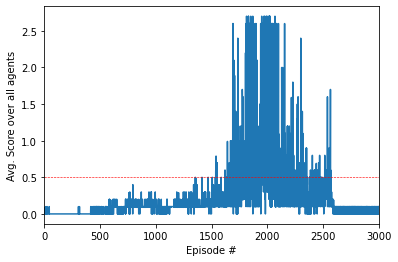

<Figure size 432x288 with 0 Axes>

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
ax.plot([0,3000],[0.5,0.5], color='r', linestyle='--', linewidth=0.6)
ax.set_xlim(0, 3000)
plt.ylabel('Avg. Score over all agents')
plt.xlabel('Episode #')
plt.show()
plt.tight_layout()
plt.savefig('figs/scores.eps')

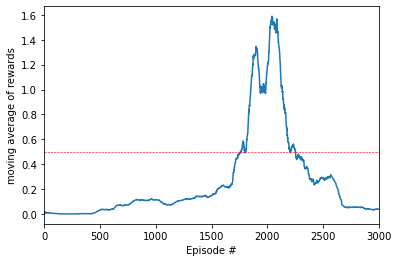

<Figure size 432x288 with 0 Axes>

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(moving_averages)+1), moving_averages)
ax.plot([0,3000],[0.5,0.5], color='r', linestyle='--', linewidth=0.6)
ax.set_xlim(0, 3000)
plt.ylabel('moving average of rewards')
plt.xlabel('Episode #')
plt.show()
plt.tight_layout()
plt.savefig('figs/moving_average.eps')

## watch agent play

In [13]:
for i, a in enumerate(agent.ddpg_agents):
    a.actor_local.load_state_dict(torch.load('actor_{}.pth'.format(i)))

In [15]:
def play(n_episodes=1):   
    for i_episode in range(1,n_episodes+1):
        env_info = env.reset(train_mode=False)[brain_name]
        # get initial state
        states = env_info.vector_observations
        agent.reset()

        while True:
            # select actions for all agents
            actions = agent.act(states)
                       
            # send action to env
            env_info = env.step(actions)[brain_name]
            
            #observe new state, reward
            next_states = env_info.vector_observations
            rewards = env_info.rewards                         
            dones = env_info.local_done                      
            
            #update state
            states = next_states
            
            if any(dones):
                break

In [16]:
play()

In [17]:
env.close()